In [10]:
!pip install -Uqq duckduckgo_search
!pip install -Uqq fastai

from ddgs import DDGS
from fastcore.all import *

def search_images(keywords,max_images=300):
    with DDGS() as ddgs :
        results=L(ddgs.images(keywords,max_results=max_images))
        return results.itemgot('image')

In [11]:
from fastdownload import download_url
from time import sleep
from fastai.vision.all import *

searches='cat','dog'
path =Path('cats-vs-dogs')
for o in searches :
    dest=(path/o)
    dest.mkdir(exist_ok=True,parents=True)
    download_images(dest,urls=search_images(f'{o} photo'))
    sleep(10)
resize_images(path/o,max_size=300,dest=path/o)


In [18]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

1

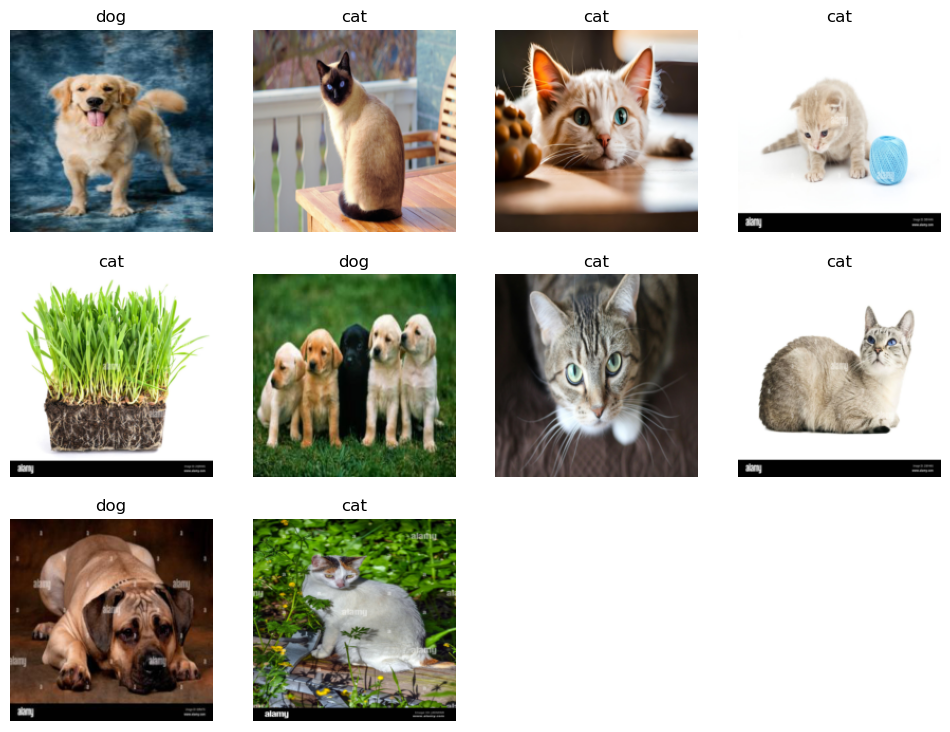

In [20]:
dls=DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2,seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192,method='squish')]).dataloaders(path)
dls.show_batch(max_n=10)

In [30]:
learn=vision_learner(dls,resnet18,metrics=error_rate)
learn.fine_tune(3)

imges='image.jpg'
pred=search_images('cat',max_images=3)
download_url(pred[0],imges)
pred_img=PILImage.create('image.jpg')
pred_class,pred_idx,pred_probs=learn.predict(pred_img)
print(pred_class)
print(pred_idx)
print(pred_probs)

epoch,train_loss,valid_loss,error_rate,time
0,1.403323,0.636971,0.307692,00:13


epoch,train_loss,valid_loss,error_rate,time
0,0.815053,0.512826,0.256410,00:17
1,0.544432,0.525764,0.153846,00:16
2,0.411228,0.554321,0.153846,00:17


cat
tensor(0)
tensor([9.9982e-01, 1.8109e-04])


<Axes: title={'center': 'Prediction: cat (99.98% confidence)'}>

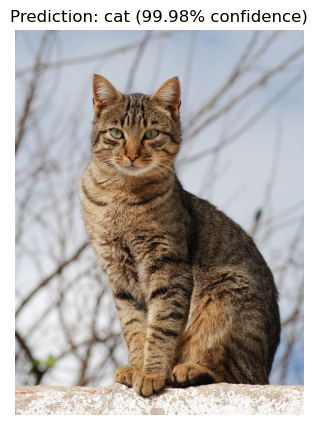

In [32]:
pred_img.show(title=f'Prediction: {pred_class} ({pred_probs[pred_idx]*100:.2f}% confidence)')

In [33]:
learn.export('models/cats_vs_dogs_model.pkl')